In [3]:
import pandas as pd 
import networkx as nx
import numpy as np 
import subprocess
import re

import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
# def nodes_within_community(G, infopath, community_index=1):
    
#     # Reading the infomap result so communities are read
#     infomap = pd.read_csv(infopath, sep=' ', skiprows=2, header=None)
#     infomap.columns = ['node','community','pagerank']
    
#     # Taking the nodes for that communities as node indexes in the list of nodes for G.
#     return [list(G.nodes)[i-1] for i in infomap[infomap.community == community_index].node.values]

# df = 0
# def hashtags_within_communities(G, infopath, community=1, df=df):

#     users_in_community = nodes_within_community(G, infopath, community_index=community)
#     df_of_users_in_community = df[df.screen_name.isin(users_in_community)]

#     print("{} users in community {}.".format(len(users_in_community), community))
#     popular_hashtags = hashtag_retriever(df_of_users_in_community)
#     print("Popular hashtags for community {}:".format(community))
    
#     return pd.Series(popular_hashtags).value_counts()


# # path to .clu community results
# def add_infomap_clusters(path, node_lists):
#     cluster_classes = pd.read_csv(path, sep=' ', skiprows=2, index_col=0, header=None)
#     cluster_classes.columns = ['Cluster','Flow']

#     return node_lists.join(cluster_classes)

# Relevant Functions to run and draw infomap

In [88]:
## Needs to run infomap community detection from terminal in order to do this.
def draw_infomap_graph(G, infopath, seed=182, pos=None, figsize=None, num_comm_threshold=None):
    """Draws the communities of G based on the infomap partition of `infopath` using networkx drawing tool.
    """
    
    if pos == None:
        pos = nx.layout.spring_layout(G, seed=seed)
        
    infomap = pd.read_csv(infopath, sep=' ', skiprows=2, header=None)
    infomap.columns = ['node','community','pagerank']
    
    community = infomap.sort_values(by='node').community.values

    if num_comm_threshold != None:
        for (ix,com) in enumerate(community):
            if com >= num_comm_threshold:
                community[ix] = num_comm_threshold
                
    node_size = infomap.sort_values(by='node').pagerank.values
    
    if figsize == None:
        plt.figure( figsize=(10, 10) )
    else:
        plt.figure( figsize=figsize )
        
    nx.draw_networkx_nodes(G, pos = pos, node_color = community, node_size = 46000*node_size,\
            alpha=0.7, cmap=plt.get_cmap("jet"))
    
    nx.draw_networkx_edges(G, pos = pos, alpha=0.40, arrowsize=15, width=0.4)
    
    plt.axis('off')
    plt.grid('False')    
    return community, node_size
    
def call_infomap(path, filename, *args):
    """Runs infomap from the terminal and returns the results with the same name of the input network `filename`.
    """

    if len(args) == 0:
        print(subprocess.getoutput(['~/infomap/Infomap '+path+filename+' '+path+' --clu -N 5 -u --silent']))
    else:
        print(subprocess.getoutput(['~/infomap/Infomap '+path+filename+' '+path+' '+' '.join(args)]))
        
def extract_codelengths( fn ):
    """ Returns the average codelength before and after applying infomap. fn is the file containing the .clu results from infomap.
    """
    infomap_file = open(fn, 'r')
    
    for line in infomap_file:
        codelength_before = re.search("from codelength (.*?) in", line)
        codelength_after = re.search("to codelength (.*?) in", line)

        try:
            return codelength_before.group(1), codelength_after.group(1)      
        except:
            return Exception("This function only takes .clu files as an input. Try running infomap with the -clu option.")
            break

# Results and experiments

In [89]:
cliques = 15
clique_size = 20
rewiring_probability = 0.15
seed = 4

G_caveman = nx.generators.community.relaxed_caveman_graph(cliques, clique_size, rewiring_probability, seed=seed)

_save = True
if _save:
    nx.write_pajek(G_caveman, 'data/caveman.net')

_plot = False
if _plot:
    plt.figure( figsize=(8, 8) )
    node_positions = nx.spring_layout(G_caveman, seed=seed)
    nx.draw( G_caveman, pos = node_positions , alpha=0.75)

# plt.tight_layout()
# plt.savefig("media/report_media/cliques.png", format='png', dpi=300)

In [114]:
cl_before

'8.222549820'

In [117]:
1.0 - float(cl_after)/float(cl_before)

0.33335733087719976


Codelength before: 8.222549820 
Codelength after: 5.481502559 
Number of communities: 15


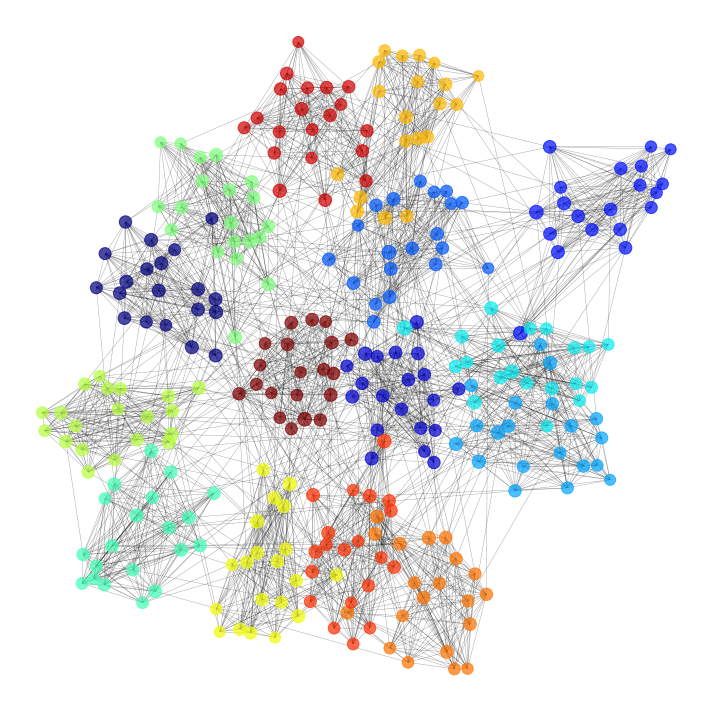

In [112]:
call_infomap("./data/", "caveman.net")

fn_infomap = './data/caveman.clu'

c, n = draw_infomap_graph(G_caveman, fn_infomap);

plt.tight_layout()

num_comms = len(set(c))
cl_before, cl_after = extract_codelengths( fn_infomap )

print( 'Codelength before: {} \nCodelength after: {} \nNumber of communities: {}'.format(cl_before, cl_after, num_comms) )
plt.savefig("media/caveman_{}cliques_rewiringp{}_cliquesize{}.png".format( cliques, clique_size, rewiring_probability ), format='png', dpi=200)

In [98]:
G_CM = nx.configuration_model( dict(G_caveman.degree).values(), create_using=nx.Graph )

_save = True
if _save:
    nx.write_pajek(G_CM, 'data/configuration_model.net')

_plot = False
if _plot:
    plt.figure( figsize=(8, 8) )
    node_positions = nx.spring_layout(G_CM, seed=seed)
    nx.draw( G_CM, pos = node_positions , alpha=0.75)


Codelength before: 8.221902138 
Codelength after: 8.221902138 
Number of communities: 1


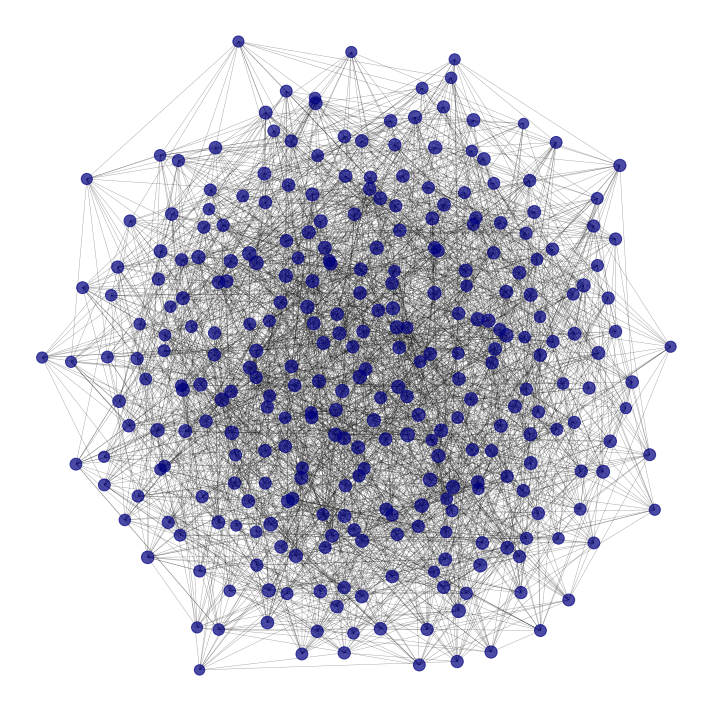

In [107]:
call_infomap("./data/", "configuration_model.net")

fn_infomap = './data/configuration_model.clu'

c, n = draw_infomap_graph(G_CM, fn_infomap);

plt.tight_layout()

num_comms = len(set(c))
cl_before, cl_after = extract_codelengths( fn_infomap )

print( 'Codelength before: {} \nCodelength after: {} \nNumber of communities: {}'.format(cl_before, cl_after, num_comms) )
plt.savefig("media/caveman_configuration_model.png", format='png', dpi=200)

In [104]:
df = pd.read_csv('data/fb_friends2014/facebook_friends_2014.csv')
df = df.iloc[:, [0,1]] + 1

G_FB = nx.from_pandas_edgelist(df, source='# source', target=' target')
Gcc = sorted(nx.connected_components(G_FB), key=len, reverse=True)
G_FB = G_FB.subgraph(Gcc[0])

_save = True
if _save:
    nx.write_pajek(G_FB, 'data/facebook_friends_2014.net')

_plot = False
if _plot:
    plt.figure( figsize=(8, 8) )
    node_positions = nx.spring_layout(G_FB, seed=seed)
    nx.draw( G_FB, pos = node_positions , alpha=0.75)

# df = df.rename(columns={'# source': 'source'})
# df.to_csv('data/facebook_friends_2014.txt', index=False, header=False, sep=' ') 

In [124]:
1 - float(cl_after)/float(cl_before)

0.26316021528566225


Codelength before: 7.821788513 
Codelength after: 5.763404964 
Number of communities: 20


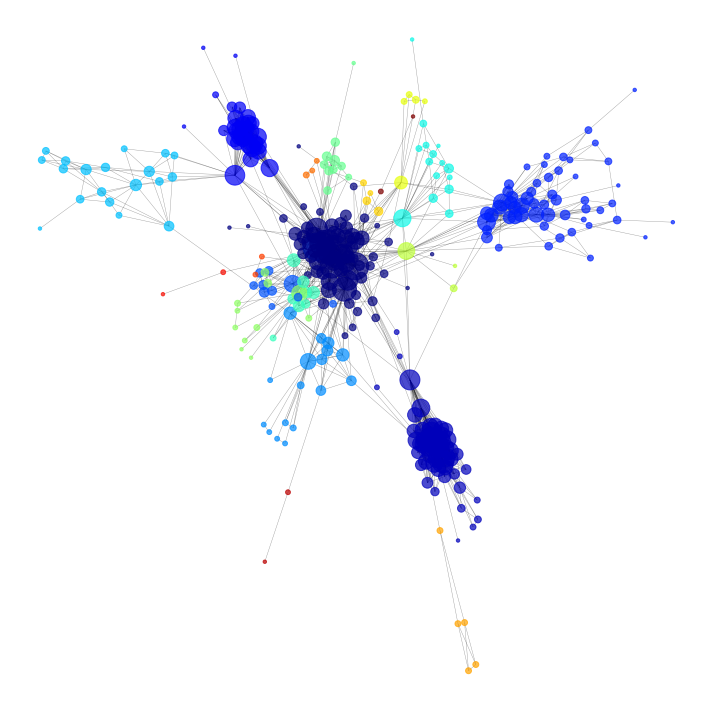

In [123]:
call_infomap("./data/", "facebook_friends_2014.net")
fn_infomap = './data/facebook_friends_2014.clu'

c, n = draw_infomap_graph(G_FB, fn_infomap, seed=0);

plt.tight_layout()

num_comms = len(set(c))
cl_before, cl_after = extract_codelengths( fn_infomap )

print( 'Codelength before: {} \nCodelength after: {} \nNumber of communities: {}'.format(cl_before, cl_after, num_comms) )
plt.savefig("media/facebook_friends_2014_lcc.png", format='png', dpi=200)